In [1]:
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import torch
from tqdm import tqdm
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = "cuda"

In [2]:
# model_id = "meta-llama/Meta-Llama-3.1-8B"

# model_id = "openai-community/gpt2-large"

model_id = "meta-llama/Llama-2-7b-hf"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
  model_id,
  device_map='auto',
  torch_dtype=torch.bfloat16,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

In [4]:
max_length = model.config.max_position_embeddings

stride = 512
seq_len = encodings.input_ids.size(1)

nlls = []
texts = []
tokens = []

char_norm_nlls = []

prev_end_loc = 0
for begin_loc in tqdm(range(0, seq_len, stride)):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
    input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    texts.append(tokenizer.decode(input_ids[0]))
    tokens.append(tokenizer.convert_ids_to_tokens(input_ids[0]))

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

        # loss is calculated using CrossEntropyLoss which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
        # to the left by 1.
        neg_log_likelihood = outputs.loss


    nlls.append(neg_log_likelihood)

    char_norm_nlls.append((trg_len-1) * neg_log_likelihood / len(texts[-1]))

    prev_end_loc = end_loc
    if end_loc == seq_len:
        break

 42%|████▏     | 281/667 [05:22<07:22,  1.15s/it]


KeyboardInterrupt: 

In [11]:
torch.stack(nlls).mean()

tensor(1.5626, device='cuda:0')

In [10]:
torch.exp(torch.stack(nlls).mean())

tensor(4.7714, device='cuda:0')

In [7]:
nlls

[tensor(1.5809, device='cuda:0'),
 tensor(1.9260, device='cuda:0'),
 tensor(2.0311, device='cuda:0'),
 tensor(2.0666, device='cuda:0'),
 tensor(1.9042, device='cuda:0'),
 tensor(1.7240, device='cuda:0'),
 tensor(1.8962, device='cuda:0'),
 tensor(2.0483, device='cuda:0'),
 tensor(1.5042, device='cuda:0'),
 tensor(1.4272, device='cuda:0'),
 tensor(1.5079, device='cuda:0'),
 tensor(1.1741, device='cuda:0'),
 tensor(1.2059, device='cuda:0'),
 tensor(1.7394, device='cuda:0'),
 tensor(1.1959, device='cuda:0'),
 tensor(1.4101, device='cuda:0'),
 tensor(1.3896, device='cuda:0'),
 tensor(1.5239, device='cuda:0'),
 tensor(1.3519, device='cuda:0'),
 tensor(0.8913, device='cuda:0'),
 tensor(0.8892, device='cuda:0'),
 tensor(1.0465, device='cuda:0'),
 tensor(1.0920, device='cuda:0'),
 tensor(0.9165, device='cuda:0'),
 tensor(1.1183, device='cuda:0'),
 tensor(1.5925, device='cuda:0'),
 tensor(1.2122, device='cuda:0'),
 tensor(1.5217, device='cuda:0'),
 tensor(1.3983, device='cuda:0'),
 tensor(1.4863

In [8]:
char_norm_nlls

[tensor(0.4189, device='cuda:0'),
 tensor(0.0632, device='cuda:0'),
 tensor(0.0654, device='cuda:0'),
 tensor(0.0661, device='cuda:0'),
 tensor(0.0601, device='cuda:0'),
 tensor(0.0545, device='cuda:0'),
 tensor(0.0613, device='cuda:0'),
 tensor(0.0657, device='cuda:0'),
 tensor(0.0480, device='cuda:0'),
 tensor(0.0455, device='cuda:0'),
 tensor(0.0483, device='cuda:0'),
 tensor(0.0386, device='cuda:0'),
 tensor(0.0404, device='cuda:0'),
 tensor(0.0592, device='cuda:0'),
 tensor(0.0406, device='cuda:0'),
 tensor(0.0484, device='cuda:0'),
 tensor(0.0480, device='cuda:0'),
 tensor(0.0529, device='cuda:0'),
 tensor(0.0476, device='cuda:0'),
 tensor(0.0322, device='cuda:0'),
 tensor(0.0337, device='cuda:0'),
 tensor(0.0411, device='cuda:0'),
 tensor(0.0437, device='cuda:0'),
 tensor(0.0382, device='cuda:0'),
 tensor(0.0477, device='cuda:0'),
 tensor(0.0675, device='cuda:0'),
 tensor(0.0517, device='cuda:0'),
 tensor(0.0618, device='cuda:0'),
 tensor(0.0548, device='cuda:0'),
 tensor(0.0561

In [18]:
torch.stack(char_norm_nlls).mean()

tensor(0.0532, device='cuda:0')

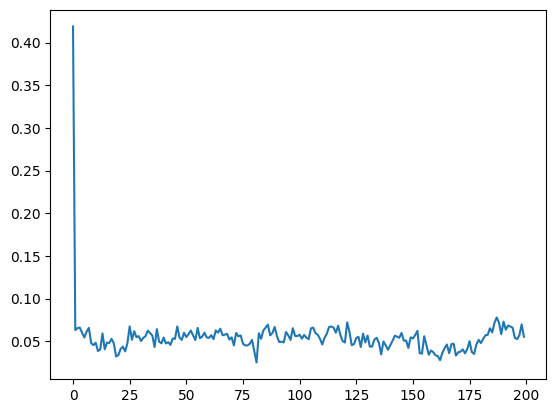

In [19]:
import matplotlib.pyplot as plt

plt.plot(torch.stack(char_norm_nlls).cpu().numpy()[:200])

(array([ 1.,  0.,  2.,  0., 18., 18., 20., 37., 36., 51., 48., 20., 20.,
         7.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.01601915, 0.02004809, 0.02407702, 0.02810596, 0.0321349 ,
        0.03616383, 0.04019277, 0.04422171, 0.04825065, 0.05227958,
        0.05630852, 0.06033746, 0.06436639, 0.06839533, 0.07242427,
        0.07645321, 0.08048214, 0.08451108, 0.08854002, 0.09256895,
        0.09659789, 0.10062683, 0.10465576, 0.1086847 , 0.11271364,
        0.11674258, 0.12077151, 0.12480045, 0.12882939, 0.13285832,
        0.13688726, 0.1409

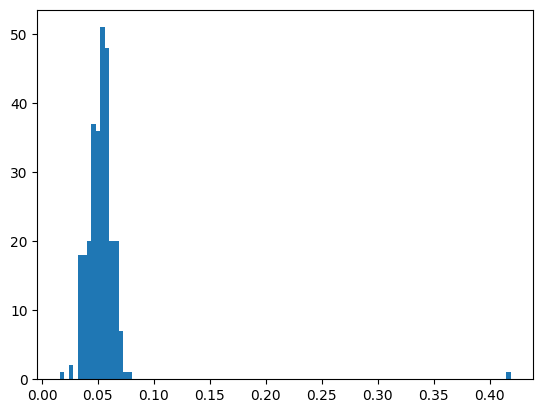

In [16]:
plt.hist([float(c) for c in char_norm_nlls], bins=100)